In [1]:
# %pip install -q matplotlib visualizer

In [2]:
import os
import re
import time
import datetime

from delta import *
from threading import Event, Thread, Lock
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col  # Добавьте этот импорт, если используете col()
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import max as max_
from pyspark.sql.functions import col

import matplotlib.pyplot as plt
from collections import defaultdict


from IPython.display import clear_output, display
from IPython.display import display, Image, clear_output, Markdown

In [3]:
# Конфигурация путей
base_path = "/Volumes/MacMini/Library/CloudStorage/GoogleDrive-dewuntain@gmail.com/Мой диск/2 Семестр/Курсовая СОБД/log_generator"

# Пути (дополняем ваши переменные)
delta_metrics_path = os.path.join(base_path, "last_user_action")  # Для метрик
delta_table_path = os.path.join(base_path, "delta")  # Для основной таблицы

In [4]:
# Инициализация Spark с Delta Lake
builder = SparkSession.builder \
    .appName("Streaming Logs to Delta") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

25/06/02 21:09:05 WARN Utils: Your hostname, Mac-mini-admin.local resolves to a loopback address: 127.0.0.1; using 192.168.0.101 instead (on interface en8)
25/06/02 21:09:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Volumes/MacMini/.ivy2/cache
The jars for the packages stored in: /Volumes/MacMini/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6049b10a-7a30-4996-9295-fd19e28ede79;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Volumes/MacMini/Library/CloudStorage/GoogleDrive-dewuntain@gmail.com/%d0%9c%d0%be%d0%b9%20%d0%b4%d0%b8%d1%81%d0%ba/2%20%d0%a1%d0%b5%d0%bc%d0%b5%d1%81%d1%82%d1%80/%d0%9a%d1%83%d1%80%d1%81%d0%be%d0%b2%d0%b0%d1%8f%20%d0%a1%d0%9e%d0%91%d0%94/log_generator/.venv/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found io.delta#delta-spark_2.12;3.3.1 in central
	found io.delta#delta-storage;3.3.1 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 71ms :: artifacts dl 2ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.3.1 from central in [default]
	io.delta#delta-storage;3.3.1 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0   |   0   |   0   ||   3   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-6049b10a-7a30-4996-9295-fd19e28ede79
	confs: [default]
	0 artifacts copied, 3 already retrieved (0kB/3ms)
25/06/02 21:09:05 

In [5]:
# Хранение текущей версии и блокировка для потокобезопасности
last_version = 0

stop_last_version_update = Event()

In [6]:
# Получение изменений с использованием Change Data Feed
def last_version_update():
    global last_version
    output = display("", display_id=True)
    while not stop_last_version_update.is_set():
        last_version = spark.sql(f"DESCRIBE HISTORY delta.`{delta_table_path}`") \
                   .select(max_("version")) \
                   .collect()[0][0]
        # print(f"{time.strftime('%Y-%m-%d %H:%M:%S')}\nПоследняя версия таблицы: {last_version}")
        # Обновляем существующий вывод вместо создания нового
        output.update(f"{time.strftime('%Y-%m-%d %H:%M:%S')} "
                      f"Последняя версия таблицы: {last_version}")
        # Ждем с возможностью прервать ожидание
        stop_last_version_update.wait(10)  # Вместо time.sleep(10)
    else:
        # Если поток остановлен, выводим сообщение
        output.update("Поток обновления версии остановлен.")

In [7]:
# Запуск в фоновом потоке
last_version_update_thread = Thread(target=last_version_update, daemon=True)
last_version_update_thread.start()

'Поток обновления версии остановлен.'

In [ ]:
# Остановка потока обновления версии
def stop_last_version_update_thread():
    print("Запрашиваю остановку пайплайна...")
    stop_last_version_update.set()  # Устанавливаем флаг остановки
    last_version_update_thread.join(timeout=15)  # Ждем завершения (максимум 30 сек)
    if last_version_update_thread.is_alive():
        print("Предупреждение: Поток не завершился корректно!")
    else:
        print("Пайплайн успешно остановлен")

# Для остановки выполните:
# stop_last_version_update_thread()

Запрашиваю остановку пайплайна...
Пайплайн успешно остановлен


Получение данных из таблиц

In [9]:
# Стандартный SQL-запрос для получения всех данных
spark.sql(f"SELECT * FROM delta.`{delta_table_path}`").show()

25/06/02 21:09:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+-------+--------------------+--------------+------------+----------+--------+------------+-------+
|          timestamp|  level|          session_id|traffic_source|  event_type|product_id|order_id|search_query|country|
+-------------------+-------+--------------------+--------------+------------+----------+--------+------------+-------+
|2025-05-29 22:43:56|WARNING|2f97c079-caa9-489...|      DESKTOP |     search |          |        |       часы |     KZ|
|2025-06-02 20:01:55|WARNING|2a753cdd-d05c-479...|      DESKTOP |   purchase |          |  83265 |            |     RU|
|2025-05-27 22:53:07|   INFO|9d6f8fd0-2ec0-4d0...|          WEB |     search |          |        |    ноутбук |     RU|
|2025-05-29 23:04:56|WARNING|40044044-2742-459...|      DESKTOP |   purchase |          |  71647 |            |     UZ|
|2025-05-29 22:49:30|   INFO|0295fafe-ed15-4a3...|      DESKTOP |add_to_cart |     3584 |        |            |     BY|
|2025-05-28 19:24:56|WARNING|f59a15b4-59

In [10]:
version_number = last_version  # Укажите нужную версию

# Использование VERSION AS OF
spark.sql(f"""
    SELECT * FROM delta.`{delta_table_path}` VERSION AS OF {version_number}
""").show()

+-------------------+-------+--------------------+--------------+------------+----------+--------+------------+-------+
|          timestamp|  level|          session_id|traffic_source|  event_type|product_id|order_id|search_query|country|
+-------------------+-------+--------------------+--------------+------------+----------+--------+------------+-------+
|2025-05-29 22:43:56|WARNING|2f97c079-caa9-489...|      DESKTOP |     search |          |        |       часы |     KZ|
|2025-06-02 20:01:55|WARNING|2a753cdd-d05c-479...|      DESKTOP |   purchase |          |  83265 |            |     RU|
|2025-05-27 22:53:07|   INFO|9d6f8fd0-2ec0-4d0...|          WEB |     search |          |        |    ноутбук |     RU|
|2025-05-29 23:04:56|WARNING|40044044-2742-459...|      DESKTOP |   purchase |          |  71647 |            |     UZ|
|2025-05-29 22:49:30|   INFO|0295fafe-ed15-4a3...|      DESKTOP |add_to_cart |     3584 |        |            |     BY|
|2025-05-28 19:24:56|WARNING|f59a15b4-59

In [11]:
# Сравнение двух версий
spark.sql(f"""
    SELECT * FROM delta.`{delta_table_path}` VERSION AS OF {version_number}
    EXCEPT
    SELECT * FROM delta.`{delta_table_path}` VERSION AS OF {version_number-1}
""").show()

+-------------------+-------+--------------------+--------------+------------+----------+--------+------------+-------+
|          timestamp|  level|          session_id|traffic_source|  event_type|product_id|order_id|search_query|country|
+-------------------+-------+--------------------+--------------+------------+----------+--------+------------+-------+
|2025-06-02 21:08:53|   INFO|97b01221-59a2-46d...|      DESKTOP |add_to_cart |     8264 |        |            |     KZ|
|2025-06-02 21:08:54|  ERROR|f3fcf831-c1ea-425...|       MOBILE |add_to_cart |     7982 |        |            |     KZ|
|2025-06-02 21:08:56|   INFO|d0bbc8ce-f29c-4ee...|       MOBILE |   purchase |          |  45249 |            |     UZ|
|2025-06-02 21:08:57|WARNING|82fca544-ab70-431...|       MOBILE |      login |          |        |            |     BY|
|2025-06-02 21:08:59|WARNING|dd6189e9-b240-402...|          WEB |     search |          |        |     камера |     UZ|
|2025-06-02 21:08:55|   INFO|20405f7c-0e

In [12]:
# Все записи последней версии
spark.sql("""
SELECT * FROM delta.`{}` 
ORDER BY timestamp DESC
""".format(delta_table_path)).show()

+-------------------+-------+--------------------+--------------+------------+----------+--------+------------+-------+
|          timestamp|  level|          session_id|traffic_source|  event_type|product_id|order_id|search_query|country|
+-------------------+-------+--------------------+--------------+------------+----------+--------+------------+-------+
|2025-06-02 21:09:24|   INFO|4213bf6b-2ba0-454...|       MOBILE |     search |          |        |       часы |     AR|
|2025-06-02 21:09:23|WARNING|ce2798ac-4477-4a0...|          WEB |     logout |          |        |            |     KZ|
|2025-06-02 21:09:22|   INFO|699b00d6-2de9-4df...|       MOBILE |   purchase |          |  41317 |            |     UZ|
|2025-06-02 21:09:21|WARNING|95ca7604-6d21-411...|       MOBILE |     logout |          |        |            |     BY|
|2025-06-02 21:09:20|   INFO|bd4c8893-26d1-4cb...|      DESKTOP |     logout |          |        |            |     RU|
|2025-06-02 21:09:19|   INFO|497eb43a-cd

In [13]:
# Базовые запросы для выборки данных
# Записи конкретного уровня (level)
spark.sql("""
SELECT timestamp, session_id, event_type 
FROM delta.`{}` 
WHERE level = 'WARNING'
ORDER BY timestamp DESC
LIMIT 10
""".format(delta_table_path)).show()

+-------------------+--------------------+----------+
|          timestamp|          session_id|event_type|
+-------------------+--------------------+----------+
|2025-06-02 21:09:23|ce2798ac-4477-4a0...|   logout |
|2025-06-02 21:09:21|95ca7604-6d21-411...|   logout |
|2025-06-02 21:09:08|67a8b294-3146-491...|   logout |
|2025-06-02 21:09:05|20405f7c-0e0d-431...|   logout |
|2025-06-02 21:09:03|387cba8e-bbe6-468...| purchase |
|2025-06-02 21:09:02|4029e029-8e13-46e...| purchase |
|2025-06-02 21:08:59|dd6189e9-b240-402...|   search |
|2025-06-02 21:08:57|82fca544-ab70-431...|    login |
|2025-06-02 21:08:46|0faebd36-5cbc-4d5...|   logout |
|2025-06-02 21:08:45|f576c49b-1c18-4a0...|   logout |
+-------------------+--------------------+----------+



In [14]:
# Анализ по странам
# Топ стран по количеству событий
spark.sql("""
SELECT country, COUNT(*) as event_count 
FROM delta.`{}` 
GROUP BY country 
ORDER BY event_count DESC
""".format(delta_table_path)).show()

+-------+-----------+
|country|event_count|
+-------+-----------+
|     AR|       4415|
|     RU|       4412|
|     BY|       4393|
|     UZ|       4354|
|     KZ|       4333|
+-------+-----------+



In [15]:
# Анализ по странам
# События по конкретной стране (например, RU)
spark.sql("""
SELECT event_type, COUNT(*) as count 
FROM delta.`{}` 
WHERE country = 'RU'
GROUP BY event_type 
ORDER BY count DESC
""".format(delta_table_path)).show()

+------------+-----+
|  event_type|count|
+------------+-----+
|     search |  895|
|   purchase |  893|
|add_to_cart |  893|
|      login |  888|
|     logout |  844|
+------------+-----+



In [16]:
# Анализ поисковых запросов
# Популярные поисковые запросы
spark.sql("""
SELECT search_query, COUNT(*) as search_count 
FROM delta.`{}` 
WHERE search_query != '' 
GROUP BY search_query 
ORDER BY search_count DESC
LIMIT 5
""".format(delta_table_path)).show()

+------------+------------+
|search_query|search_count|
+------------+------------+
|       часы |         908|
|    пылесос |         908|
|    телефон |         875|
|    ноутбук |         870|
|     камера |         860|
+------------+------------+



In [17]:
# Анализ поисковых запросов
# Поисковые запросы по странам
spark.sql("""
SELECT country, search_query, COUNT(*) as count 
FROM delta.`{}` 
WHERE search_query != ''
GROUP BY country, search_query 
ORDER BY count DESC
LIMIT 10
""".format(delta_table_path)).show()

+-------+------------+-----+
|country|search_query|count|
+-------+------------+-----+
|     RU|    пылесос |  207|
|     AR|    ноутбук |  193|
|     BY|    телефон |  192|
|     RU|       часы |  191|
|     AR|       часы |  190|
|     BY|    пылесос |  189|
|     BY|       часы |  188|
|     UZ|     камера |  188|
|     AR|    пылесос |  184|
|     AR|     камера |  184|
+-------+------------+-----+



In [18]:
# Анализ покупок
# Завершенные покупки (с order_id)
spark.sql("""
SELECT country, COUNT(order_id) as purchases 
FROM delta.`{}` 
WHERE order_id != '' 
GROUP BY country 
ORDER BY purchases DESC
""".format(delta_table_path)).show()

+-------+---------+
|country|purchases|
+-------+---------+
|     RU|      893|
|     BY|      889|
|     UZ|      888|
|     AR|      880|
|     KZ|      879|
+-------+---------+



In [19]:
# Анализ по времени
# События по минутам
spark.sql("""
SELECT 
  date_format(timestamp, 'yyyy-MM-dd HH:mm') as minute,
  COUNT(*) as events
FROM delta.`{}`
GROUP BY minute
ORDER BY minute DESC
LIMIT 10
""".format(delta_table_path)).show()

+----------------+------+
|          minute|events|
+----------------+------+
|2025-06-02 21:09|    39|
|2025-06-02 21:08|    60|
|2025-06-02 21:07|    60|
|2025-06-02 21:06|    59|
|2025-06-02 21:05|    60|
|2025-06-02 21:04|    60|
|2025-06-02 21:03|    60|
|2025-06-02 21:02|    59|
|2025-06-02 21:01|    60|
|2025-06-02 21:00|    60|
+----------------+------+



In [20]:
# Анализ по времени
# Распределение событий по типам за последний час
spark.sql("""
SELECT 
  event_type,
  COUNT(*) as count
FROM delta.`{}`
WHERE timestamp >= current_timestamp() - INTERVAL 1 HOUR
GROUP BY event_type
ORDER BY count DESC
""".format(delta_table_path)).show()

+------------+-----+
|  event_type|count|
+------------+-----+
|   purchase |  685|
|      login |  682|
|add_to_cart |  679|
|     logout |  678|
|     search |  666|
+------------+-----+



In [21]:
# Запросы с версионированием
# Сравнение двух версий
version1 = 10
version2 = 15

spark.sql("""
SELECT 
  'Version {}' as version,
  event_type,
  COUNT(*) as count
FROM delta.`{}` VERSION AS OF {}
GROUP BY event_type

UNION ALL

SELECT 
  'Version {}' as version,
  event_type,
  COUNT(*) as count
FROM delta.`{}` VERSION AS OF {}
GROUP BY event_type
""".format(version1, delta_table_path, version1, 
           version2, delta_table_path, version2)).show()

+----------+------------+-----+
|   version|  event_type|count|
+----------+------------+-----+
|Version 10|   purchase |   18|
|Version 10|add_to_cart |   25|
|Version 10|     search |   21|
|Version 10|     logout |   28|
|Version 10|      login |   23|
|Version 15|   purchase |   27|
|Version 15|add_to_cart |   37|
|Version 15|     search |   36|
|Version 15|     logout |   40|
|Version 15|      login |   31|
+----------+------------+-----+



Метрики

In [22]:
last_actions_path = os.path.join(base_path, "last_user_actions")

# 1. Показать структуру таблицы
print("Структура таблицы last_user_actions:")
spark.sql(f"DESCRIBE TABLE delta.`{last_actions_path}`").show()

Структура таблицы last_user_actions:
+----------------+---------+-------+
|        col_name|data_type|comment|
+----------------+---------+-------+
|      session_id|   string|   NULL|
|last_action_time|   string|   NULL|
|last_action_type|   string|   NULL|
|         country|   string|   NULL|
|  traffic_source|   string|   NULL|
+----------------+---------+-------+



In [23]:
# 2. Получить последние 10 записей (исправлено - используем last_action_time вместо timestamp)
print("Последние 10 действий пользователей:")
spark.sql(f"""
    SELECT * FROM delta.`{last_actions_path}`
    ORDER BY last_action_time DESC
    LIMIT 10
""").show()

Последние 10 действий пользователей:
+--------------------+-------------------+----------------+-------+--------------+
|          session_id|   last_action_time|last_action_type|country|traffic_source|
+--------------------+-------------------+----------------+-------+--------------+
|ffd25772-3ba9-446...|2025-06-02 21:09:51|    add_to_cart |     KZ|          WEB |
|2c452fec-37bb-441...|2025-06-02 21:09:50|    add_to_cart |     KZ|      DESKTOP |
|808daaed-a2ce-47d...|2025-06-02 21:09:49|         search |     AR|       MOBILE |
|f1f6c4cf-b809-426...|2025-06-02 21:09:48|         search |     KZ|          WEB |
|387cba8e-bbe6-468...|2025-06-02 21:09:47|         logout |     UZ|       MOBILE |
|50e7b413-a67e-4d1...|2025-06-02 21:09:46|       purchase |     UZ|          WEB |
|a2c328ca-40a0-470...|2025-06-02 21:09:45|    add_to_cart |     RU|       MOBILE |
|03bce2ac-63d5-460...|2025-06-02 21:09:44|         logout |     RU|      DESKTOP |
|648637c7-fe92-473...|2025-06-02 21:09:43|        

In [24]:
# 3. Получить данные на конкретную версию
print("Данные на конкретную версию:")
version = 3  # Нужная версия
spark.sql(f"""
    SELECT * FROM delta.`{last_actions_path}` VERSION AS OF {version}
    ORDER BY last_action_time DESC
""").show()

Данные на конкретную версию:
+--------------------+-------------------+----------------+-------+--------------+
|          session_id|   last_action_time|last_action_type|country|traffic_source|
+--------------------+-------------------+----------------+-------+--------------+
|5c199d64-6cd2-48d...|2025-05-27 22:13:01|    add_to_cart |     RU|          WEB |
|b7610498-1cd5-4f8...|2025-05-27 22:13:00|          login |     KZ|          WEB |
|3d7a8e07-c018-476...|2025-05-27 22:12:59|         logout |     UZ|      DESKTOP |
|9ce10aa7-d97a-4a6...|2025-05-27 22:12:58|       purchase |     RU|          WEB |
|4380bc23-d94d-46f...|2025-05-27 22:12:57|    add_to_cart |     KZ|          WEB |
|2731be95-78e2-4c6...|2025-05-27 22:12:56|    add_to_cart |     UZ|      DESKTOP |
|1d8b9a50-6d22-488...|2025-05-27 22:12:55|    add_to_cart |     RU|          WEB |
|ae88a767-e0f6-43a...|2025-05-27 22:12:54|       purchase |     BY|       MOBILE |
|b67f9ce2-417a-478...|2025-05-27 22:12:53|         search 

In [25]:
# 4. Топ пользователей по количеству действий (если есть user_id, иначе используем session_id)
print("Топ 10 пользователей по количеству действий:")
spark.sql(f"""
    SELECT session_id, COUNT(*) as action_count
    FROM delta.`{last_actions_path}`
    GROUP BY session_id
    ORDER BY action_count DESC
    LIMIT 10
""").show()

Топ 10 пользователей по количеству действий:
+--------------------+------------+
|          session_id|action_count|
+--------------------+------------+
|f1f6c4cf-b809-426...|           1|
|44af0c4c-7884-4c6...|           1|
|2c452fec-37bb-441...|           1|
|03bce2ac-63d5-460...|           1|
|ffd25772-3ba9-446...|           1|
|50e7b413-a67e-4d1...|           1|
|648637c7-fe92-473...|           1|
|808daaed-a2ce-47d...|           1|
|387cba8e-bbe6-468...|           1|
|a2c328ca-40a0-470...|           1|
+--------------------+------------+



In [26]:
# 5. Анализ по типам действий
print("Анализ по типам действий:")
spark.sql(f"""
    SELECT last_action_type, COUNT(*) as type_count
    FROM delta.`{last_actions_path}`
    GROUP BY last_action_type
    ORDER BY type_count DESC
""").show()

Анализ по типам действий:
+----------------+----------+
|last_action_type|type_count|
+----------------+----------+
|    add_to_cart |         5|
|       purchase |         2|
|         search |         2|
|         logout |         2|
|          login |         2|
+----------------+----------+



Отображение графиков

In [27]:
# Глобальные переменные для графиков
num_versions = 10 # Количество версий для отображения
interval = 5  # сек

In [28]:
def plot_traffic_by_version():
    global last_version, num_versions
    print(f"Последняя версия: {last_version}, Количество версий: {num_versions}")
    local_versions = last_version
    local_num_versions = num_versions
    
    start_version=local_versions - local_num_versions + 1
    if start_version < 0:
        start_version = 0  # Убедимся, что версия не отрицательная
        local_num_versions = local_versions + 1  # Если начальная версия 0, то количество версий будет равно последней версии + 1
    
    versions = list(range(start_version, start_version + local_num_versions))
    traffic_data = defaultdict(lambda: defaultdict(int))

    for v in versions:
        df = (
            spark.read
                .format("delta")
                .option("readChangeData", "true")
                .option("startingVersion", v)
                .option("endingVersion", v + 1)
                .load(delta_table_path)
                .filter(col("_change_type") == "insert")
        )
        grouped = df.groupBy("traffic_source").count().collect()
        for row in grouped:
            traffic_data[v][row["traffic_source"]] = row["count"]

    all_sources = sorted({src for data in traffic_data.values() for src in data})
    plot_data = {src: [traffic_data[v].get(src, 0) for v in versions] for src in all_sources}

    x = range(len(versions))
    bottom = [0] * len(versions)

    plt.figure(figsize=(14, 7))
    for src in all_sources:
        heights = plot_data[src]
        bars = plt.bar(x, heights, bottom=bottom, label=src)

        # Подписи на столбцах
        for bar, value in zip(bars, heights):
            if value > 0:
                plt.text(bar.get_x() + bar.get_width() / 2,
                         bar.get_y() + value / 2,
                         str(value), ha='center', va='center', fontsize=9, color='white')

        bottom = [b + h for b, h in zip(bottom, heights)]

    plt.xticks(x, [str(v) for v in versions])
    plt.xlabel("Версия Delta")
    plt.ylabel("Количество вставок")
    plt.title("Распределение вставок по источникам трафика для каждой версии")
    plt.legend(title="Источник трафика")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S')}\nГрафик обновлен до версии {last_version}")
    plt.show()


Последняя версия: 1937, Количество версий: 10
2025-06-02 21:10:26
График обновлен до версии 1938


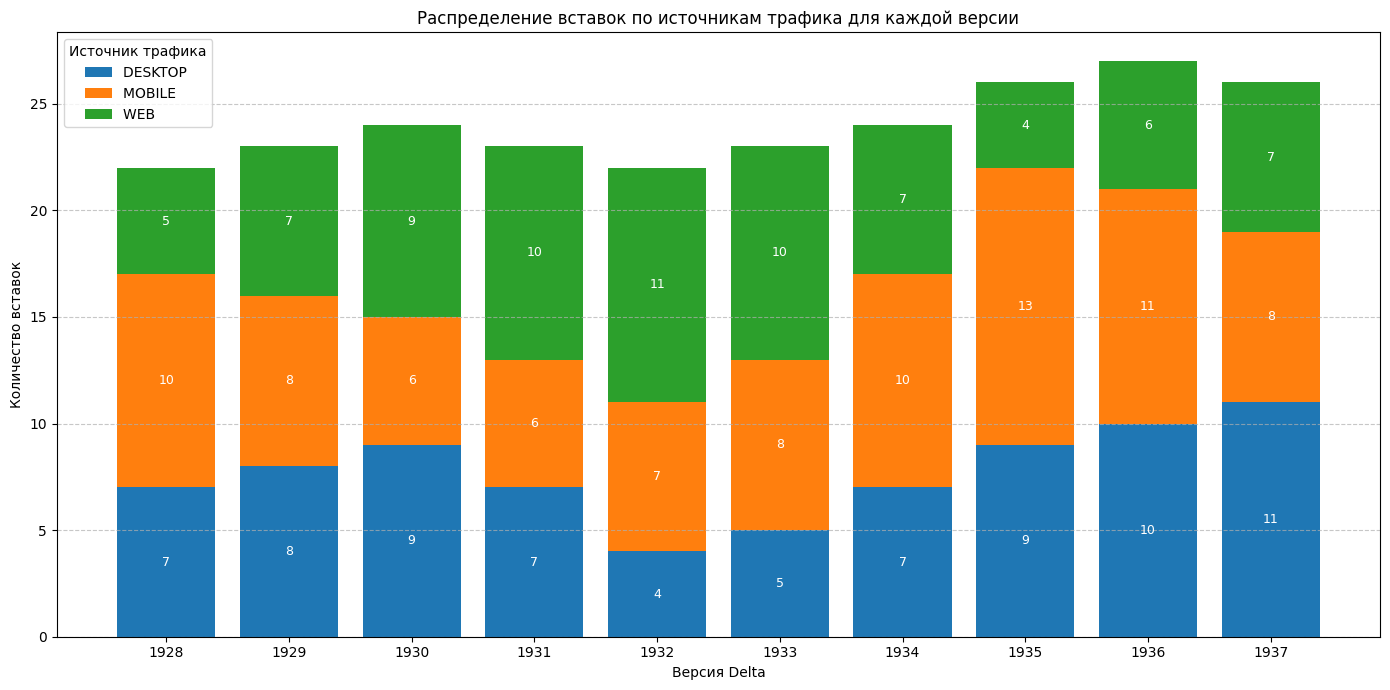

In [29]:
plot_traffic_by_version()

In [30]:
def plot_level_by_version():
    global last_version, num_versions
    print(f"Последняя версия: {last_version}, Количество версий: {num_versions}")
    local_versions = last_version
    local_num_versions = num_versions
    
    start_version=local_versions - local_num_versions + 1
    if start_version < 0:
        start_version = 0  # Убедимся, что версия не отрицательная
        local_num_versions = local_versions + 1  # Если начальная версия 0, то количество версий будет равно последней версии + 1
    
    versions = list(range(start_version, start_version + local_num_versions))
    level_data = defaultdict(lambda: defaultdict(int))

    for v in versions:
        df = (
            spark.read
                .format("delta")
                .option("readChangeData", "true")
                .option("startingVersion", v)
                .option("endingVersion", v + 1)
                .load(delta_table_path)
                .filter(col("_change_type") == "insert")
        )
        grouped = df.groupBy("level").count().collect()
        for row in grouped:
            level_data[v][row["level"]] = row["count"]

    all_levels = sorted({lvl for data in level_data.values() for lvl in data})
    plot_data = {lvl: [level_data[v].get(lvl, 0) for v in versions] for lvl in all_levels}

    # Построение графика
    plt.close("all")
    plt.figure(figsize=(14, 7))
    x = range(len(versions))
    bottom = [0] * len(versions)

    for lvl in all_levels:
        heights = plot_data[lvl]
        bars = plt.bar(x, heights, bottom=bottom, label=lvl)

        for bar, value in zip(bars, heights):
            if value > 0:
                plt.text(bar.get_x() + bar.get_width() / 2,
                         bar.get_y() + value / 2,
                         str(value), ha='center', va='center', fontsize=9, color='white')

        bottom = [b + h for b, h in zip(bottom, heights)]

    plt.xticks(x, [str(v) for v in versions])
    plt.xlabel("Версия Delta")
    plt.ylabel("Количество вставок")
    plt.title("Распределение вставок по уровню логирования (level) для каждой версии")
    plt.legend(title="Уровень")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S')}\nГрафик обновлен до версии {local_versions}")
    plt.show()


Последняя версия: 1938, Количество версий: 10
2025-06-02 21:10:47
График обновлен до версии 1938


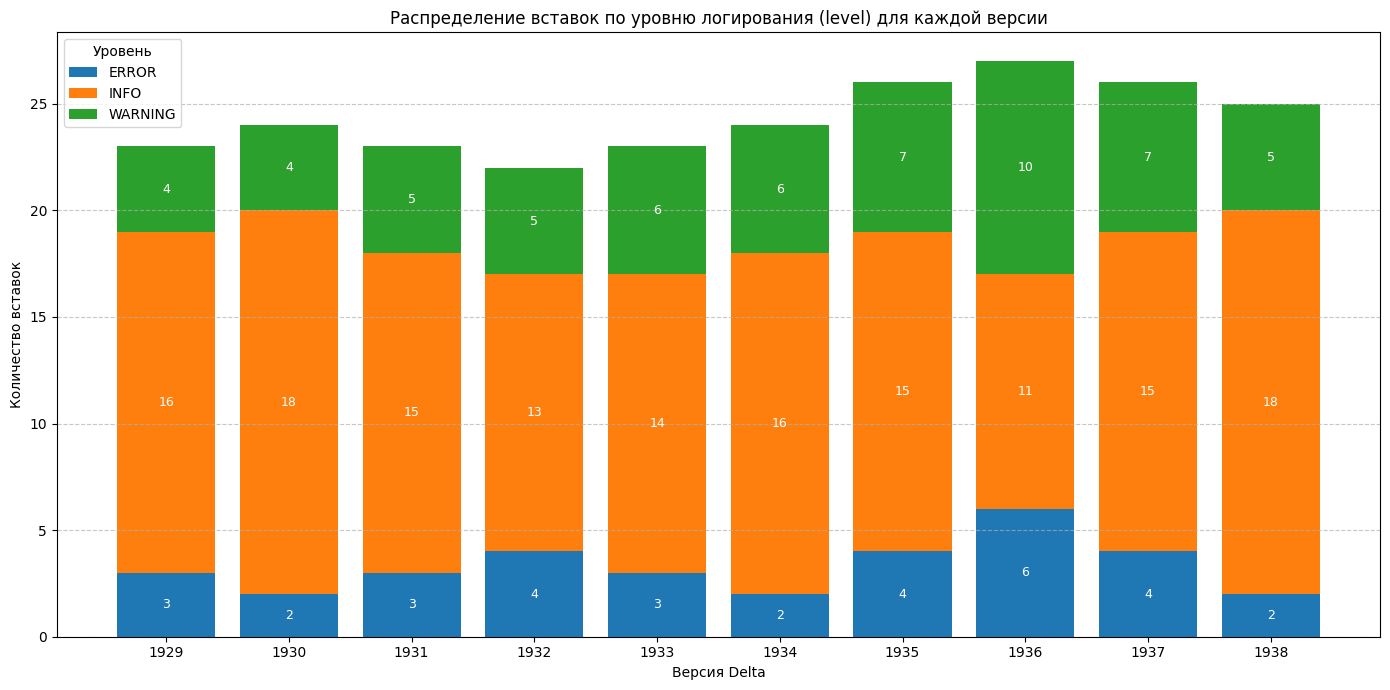

In [31]:
plot_level_by_version()

In [32]:
def plot_events_by_version():
    global last_version, num_versions
    print(f"Последняя версия: {last_version}, Количество версий: {num_versions}")
    local_versions = last_version
    local_num_versions = num_versions
    
    start_version=local_versions - local_num_versions + 1
    if start_version < 0:
        start_version = 0  # Убедимся, что версия не отрицательная
        local_num_versions = local_versions + 1  # Если начальная версия 0, то количество версий будет равно последней версии + 1
    
    versions = list(range(start_version, start_version + local_num_versions))
    event_data = defaultdict(lambda: defaultdict(int))

    # Сбор данных по версиям
    for v in versions:
        df = (
            spark.read
                .format("delta")
                .option("readChangeData", "true")
                .option("startingVersion", v)
                .option("endingVersion", v + 1)
                .load(delta_table_path)
                .filter(col("_change_type") == "insert")
        )
        for row in df.groupBy("event_type").count().collect():
            event_data[v][row["event_type"]] = row["count"]

    # Все уникальные event_type
    all_events = sorted({evt for d in event_data.values() for evt in d})

    # Подготовка данных для графика
    x = range(len(versions))
    bottom = [0] * len(versions)

    plt.figure(figsize=(14, 7))
    for evt in all_events:
        heights = [event_data[v].get(evt, 0) for v in versions]
        bars = plt.bar(x, heights, bottom=bottom, label=evt)
        for bar, val in zip(bars, heights):
            if val > 0:
                plt.text(bar.get_x() + bar.get_width() / 2,
                         bar.get_y() + val / 2,
                         str(val), ha='center', va='center', fontsize=9, color='white')
        bottom = [b + h for b, h in zip(bottom, heights)]

    plt.xticks(x, [str(v) for v in versions])
    plt.xlabel("Версия Delta")
    plt.ylabel("Количество вставок")
    plt.title("Вставки по (event_type)")
    plt.legend(title="Действия пользователей", bbox_to_anchor=(1.05, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S')}\nГрафик обновлен до версии {local_versions}")
    plt.show()


Последняя версия: 1940, Количество версий: 10
2025-06-02 21:11:07
График обновлен до версии 1940


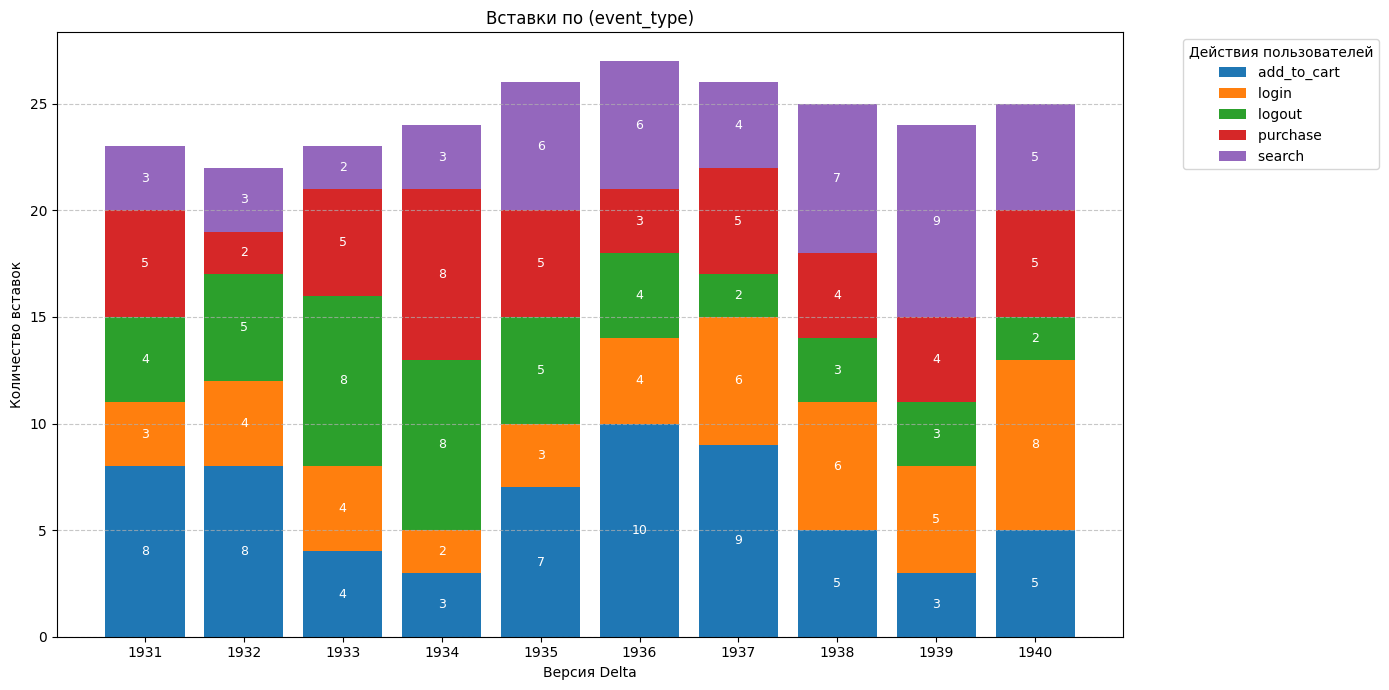

In [33]:
plot_events_by_version()

In [34]:
def plot_country_by_version():
    global last_version, num_versions
    print(f"Последняя версия: {last_version}, Количество версий: {num_versions}")
    local_versions = last_version
    local_num_versions = num_versions
    
    start_version=local_versions - local_num_versions + 1
    if start_version < 0:
        start_version = 0  # Убедимся, что версия не отрицательная
        local_num_versions = local_versions + 1  # Если начальная версия 0, то количество версий будет равно последней версии + 1
    
    versions = list(range(start_version, start_version + local_num_versions))
    country_data = defaultdict(lambda: defaultdict(int))

    # Сбор данных по версиям
    for v in versions:
        df = (
            spark.read
                .format("delta")
                .option("readChangeData", "true")
                .option("startingVersion", v)
                .option("endingVersion", v + 1)
                .load(delta_table_path)
                .filter(col("_change_type") == "insert")
        )
        for row in df.groupBy("country").count().collect():
            country_data[v][row["country"]] = row["count"]

    # Все уникальные страны
    all_countries = sorted({cty for d in country_data.values() for cty in d})

    # Подготовка данных для графика
    x = range(len(versions))
    bottom = [0] * len(versions)

    plt.figure(figsize=(14, 7))
    for country in all_countries:
        heights = [country_data[v].get(country, 0) for v in versions]
        bars = plt.bar(x, heights, bottom=bottom, label=country)
        for bar, val in zip(bars, heights):
            if val > 0:
                plt.text(bar.get_x() + bar.get_width() / 2,
                         bar.get_y() + val / 2,
                         str(val), ha='center', va='center', fontsize=9, color='white')
        bottom = [b + h for b, h in zip(bottom, heights)]

    plt.xticks(x, [str(v) for v in versions])
    plt.xlabel("Версия Delta")
    plt.ylabel("Количество вставок")
    plt.title("Вставки по странам (country)")
    plt.legend(title="Страна", bbox_to_anchor=(1.05, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S')}\nГрафик обновлен до версии {local_versions}")
    plt.show()


Последняя версия: 1942, Количество версий: 10
2025-06-02 21:11:27
График обновлен до версии 1942


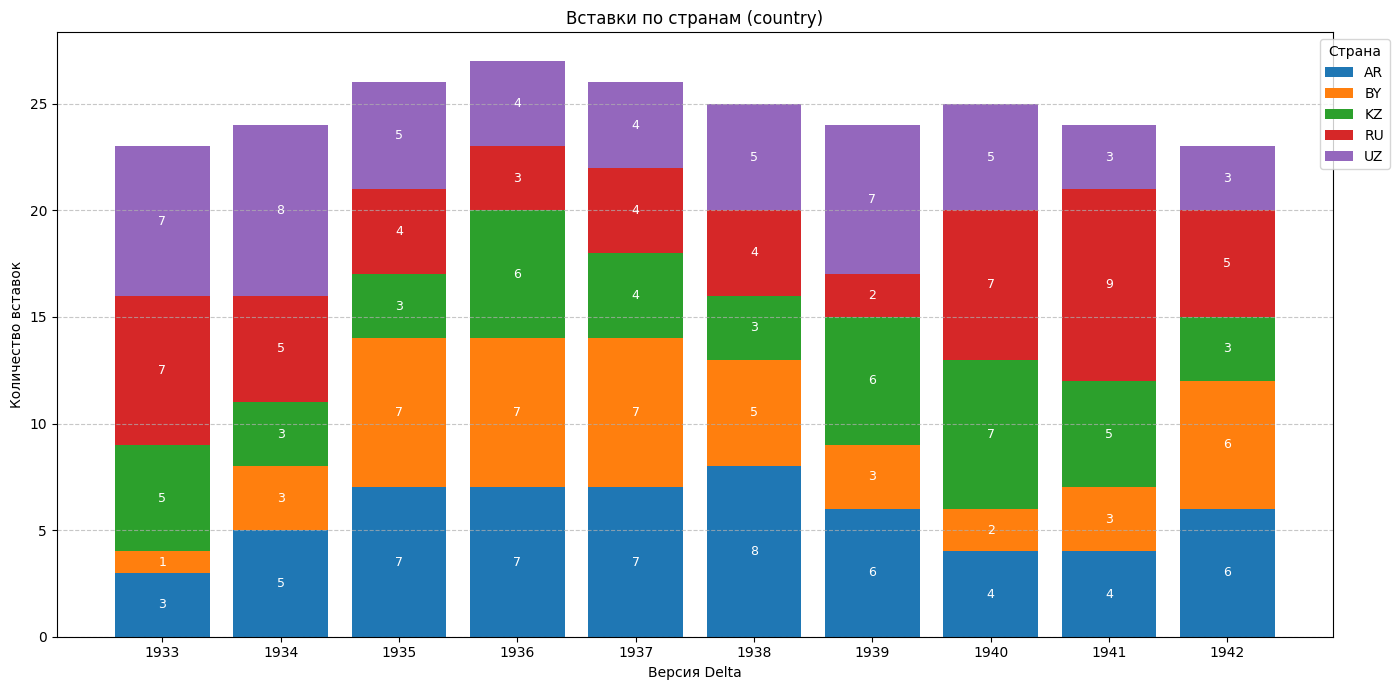

In [35]:
plot_country_by_version()

In [36]:
def plot_search_query_by_version():
    global last_version, num_versions
    print(f"Последняя версия: {last_version}, Количество версий: {num_versions}")
    local_versions = last_version
    local_num_versions = num_versions
    
    start_version=local_versions - local_num_versions + 1
    if start_version < 0:
        start_version = 0  # Убедимся, что версия не отрицательная
        local_num_versions = local_versions + 1  # Если начальная версия 0, то количество версий будет равно последней версии + 1
    
    versions = list(range(start_version, start_version + local_num_versions))
    query_data = defaultdict(lambda: defaultdict(int))

    # Сбор данных по версиям
    for v in versions:
        df = (
            spark.read
                .format("delta")
                .option("readChangeData", "true")
                .option("startingVersion", v)
                .option("endingVersion", v + 1)
                .load(delta_table_path)
                .filter((col("_change_type") == "insert") & (col("search_query").isNotNull()) & (col("search_query") != ""))
        )
        for row in df.groupBy("search_query").count().collect():
            query_data[v][row["search_query"]] = row["count"]

    # Все уникальные запросы
    all_queries = sorted({q for d in query_data.values() for q in d})

    # Подготовка данных для графика
    x = range(len(versions))
    bottom = [0] * len(versions)

    plt.figure(figsize=(16, 8))
    for query in all_queries:
        heights = [query_data[v].get(query, 0) for v in versions]
        bars = plt.bar(x, heights, bottom=bottom, label=query)
        for bar, val in zip(bars, heights):
            if val > 0:
                plt.text(bar.get_x() + bar.get_width() / 2,
                         bar.get_y() + val / 2,
                         str(val), ha='center', va='center', fontsize=9, color='white')
        bottom = [b + h for b, h in zip(bottom, heights)]

    plt.xticks(x, [str(v) for v in versions])
    plt.xlabel("Версия Delta")
    plt.ylabel("Количество вставок")
    plt.title("Вставки по поисковым запросам (search_query)")
    plt.legend(title="Поисковый запрос", bbox_to_anchor=(1.05, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S')}\nГрафик обновлен до версии {local_versions}")
    plt.show()


Последняя версия: 1944, Количество версий: 10
2025-06-02 21:11:47
График обновлен до версии 1944


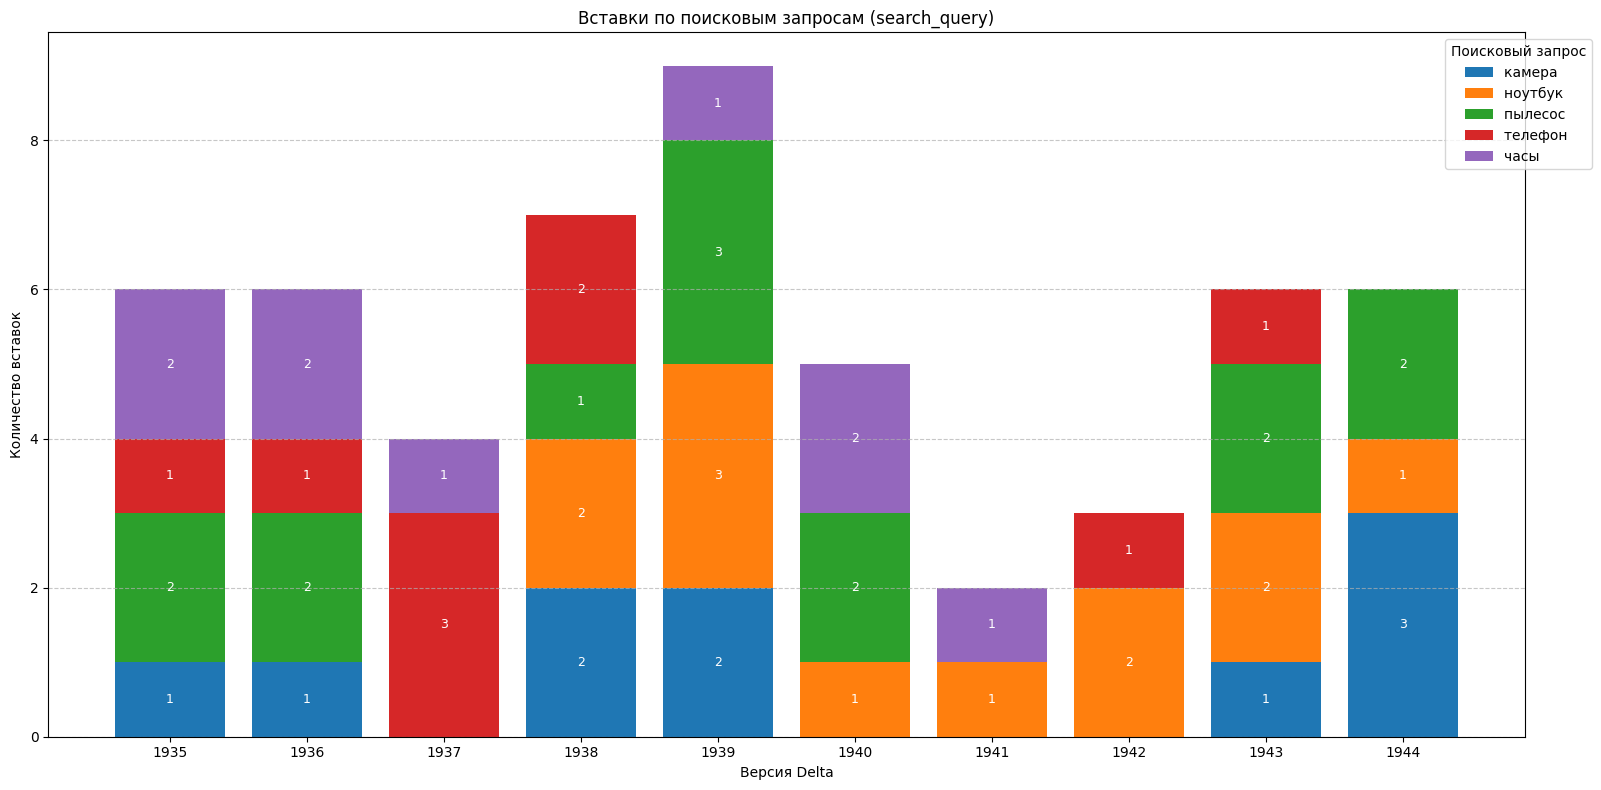

In [37]:
plot_search_query_by_version()

In [38]:
# Обновление графика в цикле
stop_show_plot_event = Event()
last_update = 1
cycle_thread_level = None

In [39]:
def cycle_with_stop_event(func):
    global last_update
    func_name = func.__name__
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S')}\nЗапущен поток для функции {func_name}")
    
    while not stop_show_plot_event.is_set():
        if last_update < last_version:
            last_update = last_version
            func()
        time.sleep(interval)
    else:
        print(f"{time.strftime('%Y-%m-%d %H:%M:%S')}\nПоток {func_name} остановлен.")

In [40]:
def stop_plotting(timeout=15):
    global stop_show_plot_event
    stop_show_plot_event.set()
    if cycle_thread_level:
        cycle_thread_level.join(timeout=timeout)
        if cycle_thread_level.is_alive():
            print("Предупреждение: поток не завершился в течение заданного времени")
        else:
            print("Поток успешно остановлен")
    # Всегда сбрасываем флаг после остановки
    stop_show_plot_event.clear()

In [41]:
def start_plotting(func):
    global stop_show_plot_event, cycle_thread_level
    # Сбрасываем флаг остановки
    stop_show_plot_event.clear()
    # Если поток уже запущен, сначала останавливаем его
    if cycle_thread_level and cycle_thread_level.is_alive():
        stop_plotting()
    # Запускаем новый поток
    cycle_thread_level = Thread(
        target=cycle_with_stop_event,
        args=(func,),
        daemon=True
    )
    cycle_thread_level.start()
    return cycle_thread_level

2025-06-02 21:14:22
Запущен поток для функции plot_level_by_version
Последняя версия: 1959, Количество версий: 10


<Thread(Thread-8, started daemon 6328823808)>

2025-06-02 21:14:42
График обновлен до версии 1959


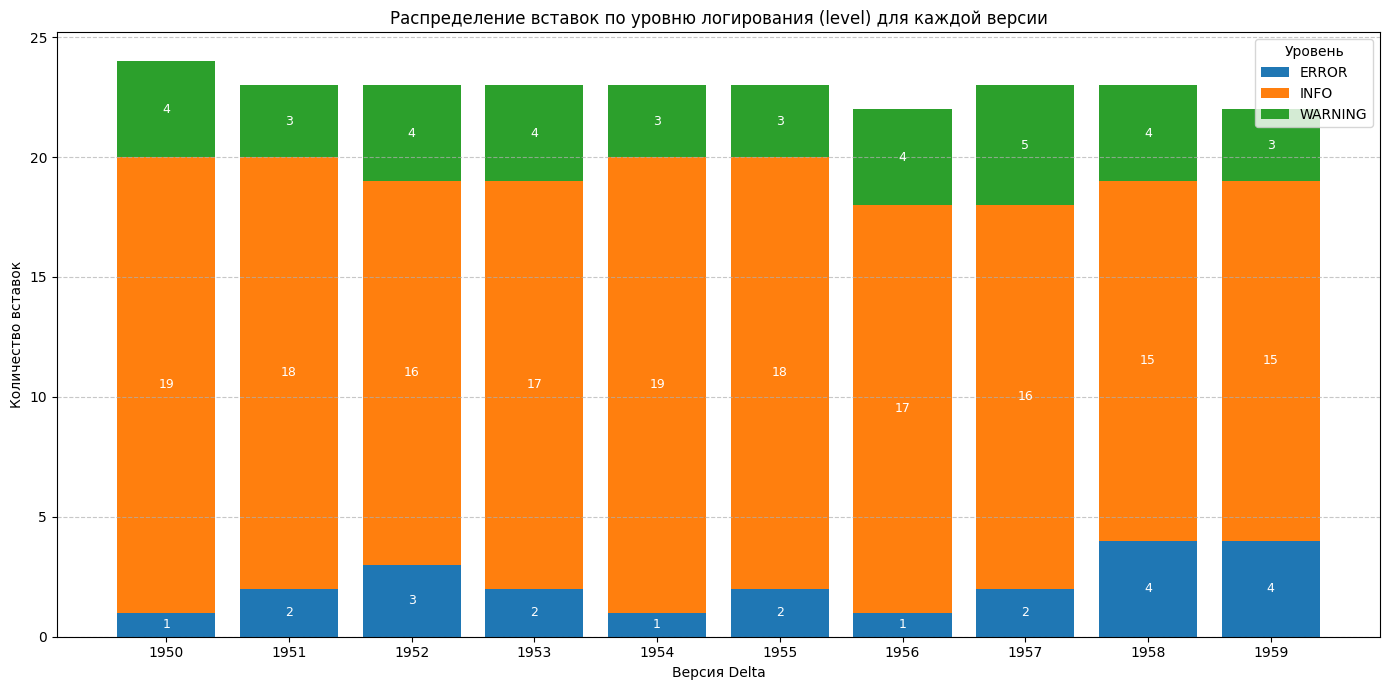

Последняя версия: 1961, Количество версий: 10
2025-06-02 21:15:07
График обновлен до версии 1961


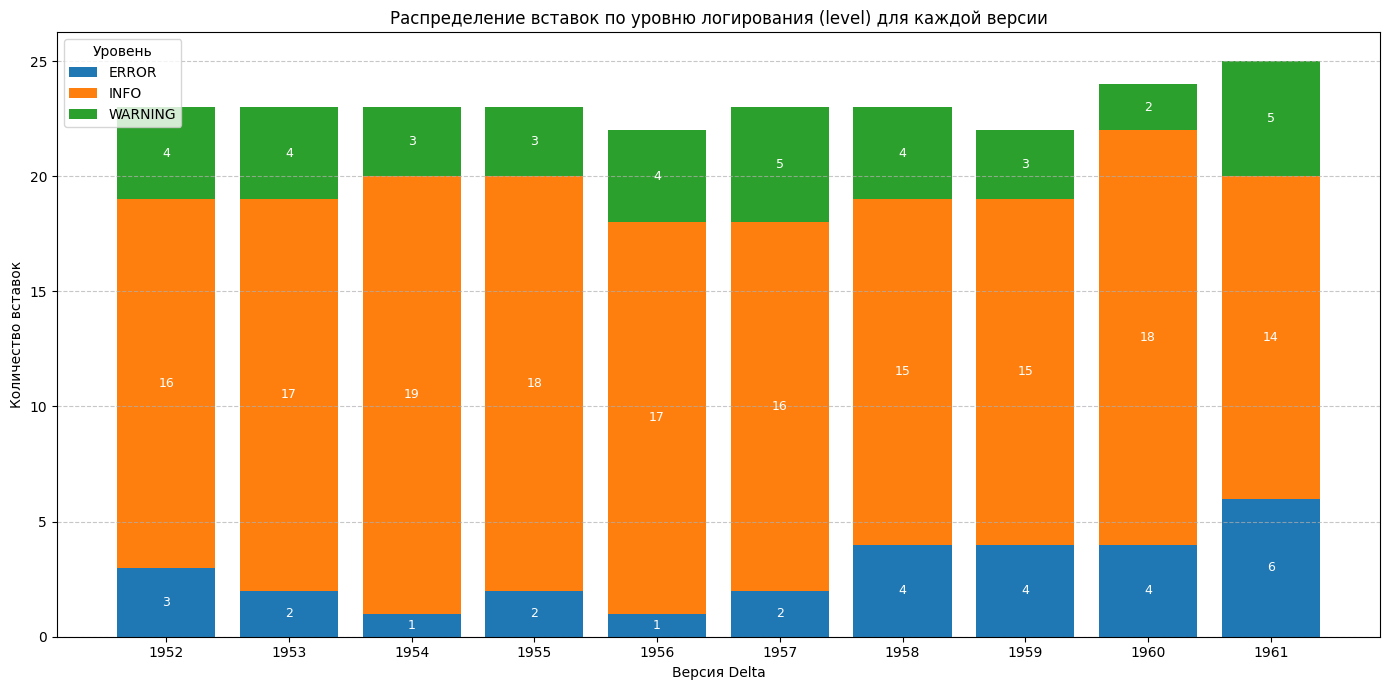

Последняя версия: 1964, Количество версий: 10
2025-06-02 21:15:31
График обновлен до версии 1964


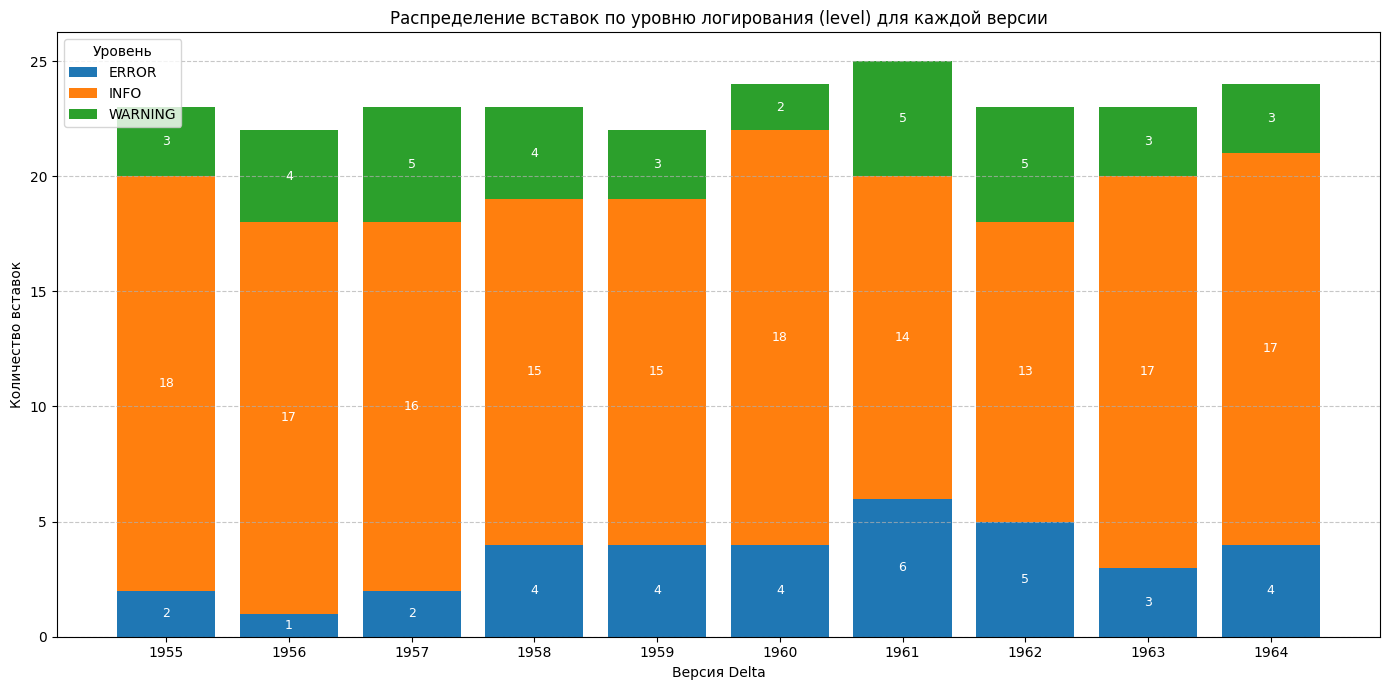

Последняя версия: 1965, Количество версий: 10
2025-06-02 21:15:55
График обновлен до версии 1965


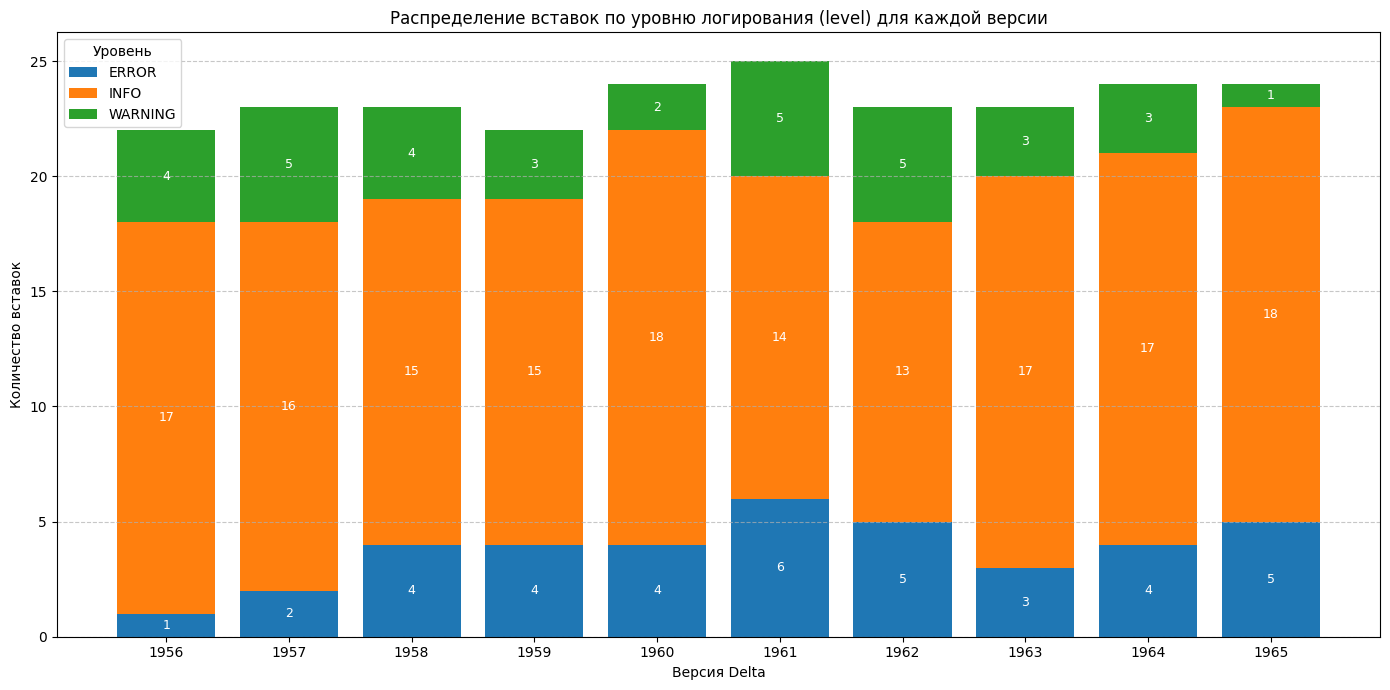

Последняя версия: 1967, Количество версий: 10
2025-06-02 21:16:20
График обновлен до версии 1967


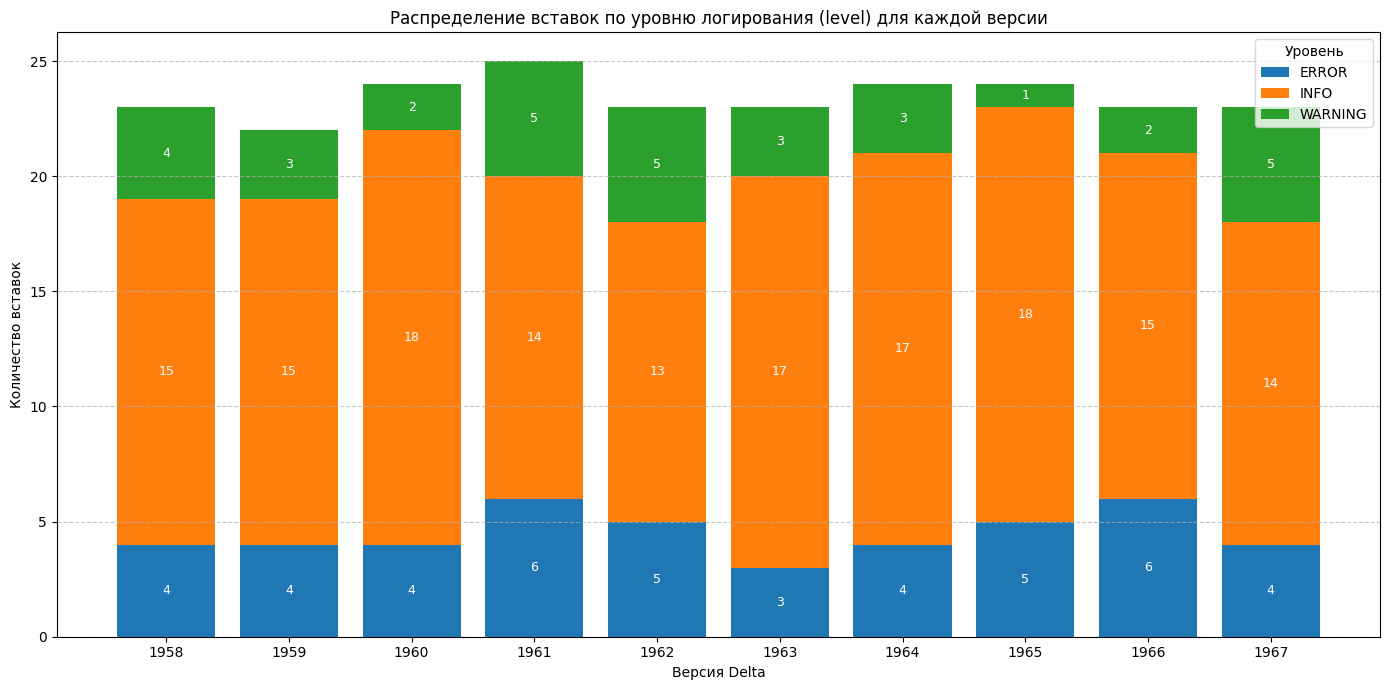

2025-06-02 21:16:25
Поток plot_level_by_version остановлен.


In [45]:
start_plotting(plot_level_by_version)

In [46]:
stop_plotting()

Поток успешно остановлен
